In [1]:
%cd ../..

/home/work/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.dynamical_ball import dynamical_ball
from examples.bouncing_ball import bouncing_ball_data
from combinators.model import foldable
from combinators.inference import importance, mcmc
from combinators import utils

In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
## dataset parameters
T = 100 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [6]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [7]:
num_particles = (100,)

In [8]:
init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)

In [9]:
bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)

In [10]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [11]:
def accumulate_trajectory(inference):
    result = torch.zeros(*num_particles, len(trajectory), 2)
    result[:, 0] = inference['Reduce/Step(0)/InitBallDynamics']['position_0'].value
    for t in range(len(trajectory) - 1):
        result[:, t+1] = result[:, t] + inference['Reduce/Step(%d)/StepBallDynamics' % t]['velocity_%d' % t].value
    return result

In [12]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [13]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [14]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [15]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [16]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [17]:
def proposal_model():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return foldable.Reduce(foldable.Step(step_proposal, initializer=init_proposal),
                           lambda: range(T))

In [18]:
def training_initializer():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    return importance.Importance(init_bouncing_ball, init_proposal)

In [19]:
def training_step():
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return importance.Importance(bouncing_ball_step, step_proposal)

In [20]:
def training_model():
    return foldable.Reduce(foldable.Step(training_step(), initializer=training_initializer()), lambda: range(T))

02/21/2019 18:41:25 ELBO=-2.48850708e+02 at epoch 1
02/21/2019 18:41:26 ELBO=-2.40200073e+02 at epoch 2
02/21/2019 18:41:26 ELBO=-2.36318817e+02 at epoch 3
02/21/2019 18:41:26 ELBO=-2.40510071e+02 at epoch 4
02/21/2019 18:41:27 ELBO=-2.26098969e+02 at epoch 5
02/21/2019 18:41:27 ELBO=-2.42355515e+02 at epoch 6
02/21/2019 18:41:27 ELBO=-2.19698517e+02 at epoch 7
02/21/2019 18:41:28 ELBO=-2.31022049e+02 at epoch 8
02/21/2019 18:41:28 ELBO=-2.37443130e+02 at epoch 9
02/21/2019 18:41:29 ELBO=-2.34806976e+02 at epoch 10
02/21/2019 18:41:29 ELBO=-2.32266113e+02 at epoch 11
02/21/2019 18:41:29 ELBO=-2.26902344e+02 at epoch 12
02/21/2019 18:41:30 ELBO=-2.32635269e+02 at epoch 13
02/21/2019 18:41:30 ELBO=-2.26984360e+02 at epoch 14
02/21/2019 18:41:30 ELBO=-2.38252548e+02 at epoch 15
02/21/2019 18:41:31 ELBO=-2.32068634e+02 at epoch 16
02/21/2019 18:41:31 ELBO=-2.32940430e+02 at epoch 17
02/21/2019 18:41:31 ELBO=-2.35255020e+02 at epoch 18
02/21/2019 18:41:32 ELBO=-2.23865616e+02 at epoch 19
02

Epoch   264: reducing learning rate of group 0 to 5.0000e-02.


02/21/2019 18:43:14 ELBO=-2.03596100e+02 at epoch 266
02/21/2019 18:43:15 ELBO=-2.04581177e+02 at epoch 267
02/21/2019 18:43:15 ELBO=-2.03395889e+02 at epoch 268
02/21/2019 18:43:16 ELBO=-2.06190445e+02 at epoch 269
02/21/2019 18:43:16 ELBO=-2.11340225e+02 at epoch 270
02/21/2019 18:43:17 ELBO=-2.01849350e+02 at epoch 271
02/21/2019 18:43:17 ELBO=-2.12087540e+02 at epoch 272
02/21/2019 18:43:18 ELBO=-2.16391663e+02 at epoch 273
02/21/2019 18:43:18 ELBO=-2.10042114e+02 at epoch 274
02/21/2019 18:43:18 ELBO=-2.03667755e+02 at epoch 275
02/21/2019 18:43:19 ELBO=-2.05578415e+02 at epoch 276
02/21/2019 18:43:19 ELBO=-2.06367889e+02 at epoch 277
02/21/2019 18:43:20 ELBO=-2.05346741e+02 at epoch 278
02/21/2019 18:43:20 ELBO=-2.14115021e+02 at epoch 279
02/21/2019 18:43:20 ELBO=-2.03717285e+02 at epoch 280
02/21/2019 18:43:21 ELBO=-2.07414536e+02 at epoch 281
02/21/2019 18:43:21 ELBO=-2.05954788e+02 at epoch 282
02/21/2019 18:43:21 ELBO=-2.07563873e+02 at epoch 283
02/21/2019 18:43:22 ELBO=-2.

Epoch   456: reducing learning rate of group 0 to 2.5000e-02.


02/21/2019 18:44:32 ELBO=-2.03393158e+02 at epoch 458
02/21/2019 18:44:32 ELBO=-2.02956436e+02 at epoch 459
02/21/2019 18:44:33 ELBO=-2.02929398e+02 at epoch 460
02/21/2019 18:44:33 ELBO=-2.01339233e+02 at epoch 461
02/21/2019 18:44:34 ELBO=-2.03210831e+02 at epoch 462
02/21/2019 18:44:34 ELBO=-2.02809265e+02 at epoch 463
02/21/2019 18:44:34 ELBO=-2.05091064e+02 at epoch 464
02/21/2019 18:44:35 ELBO=-2.02103180e+02 at epoch 465
02/21/2019 18:44:35 ELBO=-2.01782043e+02 at epoch 466
02/21/2019 18:44:36 ELBO=-2.03149307e+02 at epoch 467
02/21/2019 18:44:36 ELBO=-2.01665405e+02 at epoch 468
02/21/2019 18:44:37 ELBO=-2.03740036e+02 at epoch 469
02/21/2019 18:44:37 ELBO=-2.01268326e+02 at epoch 470
02/21/2019 18:44:37 ELBO=-2.01675110e+02 at epoch 471
02/21/2019 18:44:38 ELBO=-2.03623672e+02 at epoch 472
02/21/2019 18:44:38 ELBO=-2.03681976e+02 at epoch 473
02/21/2019 18:44:39 ELBO=-2.02777664e+02 at epoch 474
02/21/2019 18:44:39 ELBO=-2.03728394e+02 at epoch 475
02/21/2019 18:44:39 ELBO=-2.

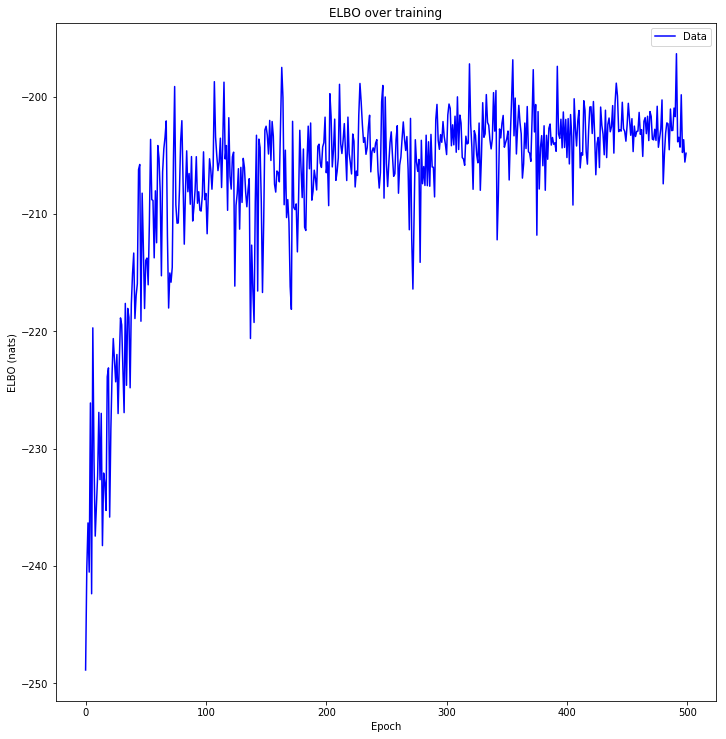

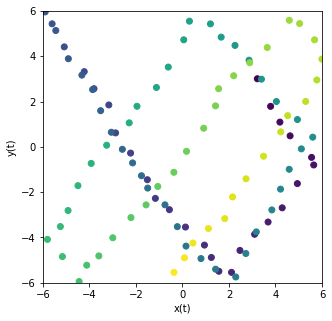

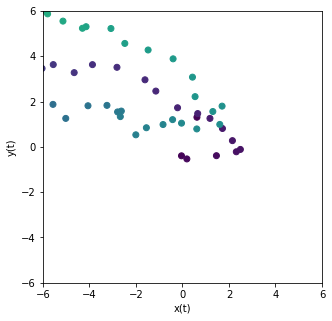

In [21]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)

    importance_sampler = training_model()
    
    inference, trained_params, elbos = importance.variational_importance(
        importance_sampler, 500, data,
        use_cuda=False, lr=1e-1, inclusive_kl=False,
        patience=100,
    )
    utils.plot_evidence_bounds(elbos, True)
    
    bouncing_ball_posterior = mcmc.reduce_resample_move_smc(importance_sampler.folder.operator, lambda: range(T),
                                                            initializer=importance_sampler.folder._initializer, moves=5)
    (direction, position, uncertainty), inference, _ = bouncing_ball_posterior(data=data)
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce/Step(%d)/StepBallDynamics' % t]['velocity_%d' % t].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_original_trajectory(trajectory, T, s)
    graph_inferred_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    plt.close('all')

In [22]:
trained_params

"{'direction__loc': 'tensor([ 0.4027, -0.7405], grad_fn=<CloneBackward>)', 'direction__scale': 'tensor([-1.4535, -0.5506], grad_fn=<CloneBackward>)', 'position_0__covariance_matrix': 'tensor([[ 0.0166,  0.0000],\n        [ 0.2207, -0.1806]], grad_fn=<CloneBackward>)', 'position_0__loc': 'tensor([3.0500, 2.1614], grad_fn=<CloneBackward>)', 'uncertainty__loc': 'tensor([2.0437, 2.2445], grad_fn=<CloneBackward>)', 'uncertainty__scale': 'tensor([-1.0570, -0.9403], grad_fn=<CloneBackward>)', 'velocities__loc': 'tensor([[ 1.0622, -0.7293],\n        [ 0.7136, -0.5168],\n        [ 0.8711, -0.5664],\n        [ 0.3302, -0.5005],\n        [-0.0911, -0.3424],\n        [-0.3551, -0.5514],\n        [-0.6407, -0.7972],\n        [-0.1398, -0.4165],\n        [-0.7215, -0.9507],\n        [-0.8043, -0.7179],\n        [-0.5883, -0.7279],\n        [-0.7606, -0.2429],\n        [-0.8612,  0.6967],\n        [-0.8176,  0.7218],\n        [-0.2295,  0.9868],\n        [-0.5544,  0.8000],\n        [-0.5239,  0.5451

In [23]:
for t in range(T+1):
    print('Position at time %d' % t, data['position_%d' % t])

Position at time 0 tensor([3.2214, 3.0085])
Position at time 1 tensor([3.7915, 1.7904])
Position at time 2 tensor([4.1923, 1.0948])
Position at time 3 tensor([4.6297, 0.4879])
Position at time 4 tensor([ 5.5540, -0.4625])
Position at time 5 tensor([ 5.6467, -0.7972])
Position at time 6 tensor([ 4.9422, -1.6200])
Position at time 7 tensor([ 4.2904, -2.6900])
Position at time 8 tensor([ 3.6831, -3.3164])
Position at time 9 tensor([ 3.1042, -3.8569])
Position at time 10 tensor([ 2.4733, -4.5707])
Position at time 11 tensor([ 2.1105, -5.5382])
Position at time 12 tensor([ 1.5671, -5.4903])
Position at time 13 tensor([ 1.2436, -4.8808])
Position at time 14 tensor([ 0.9460, -4.3351])
Position at time 15 tensor([ 0.1297, -3.5387])
Position at time 16 tensor([-0.5610, -2.7719])
Position at time 17 tensor([-1.1652, -2.2724])
Position at time 18 tensor([-1.5097, -1.4491])
Position at time 19 tensor([-2.2313, -0.2727])
Position at time 20 tensor([-2.8764,  0.6176])
Position at time 21 tensor([-3.

In [24]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])

Inferred position at time 0 tensor([0.6232, 1.3102])
Inferred position at time 1 tensor([-0.0413, -0.3934])
Inferred position at time 2 tensor([ 0.1898, -0.5307])
Inferred position at time 3 tensor([ 1.4614, -0.3876])
Inferred position at time 4 tensor([ 2.3167, -0.2150])
Inferred position at time 5 tensor([ 2.4916, -0.1117])
Inferred position at time 6 tensor([2.1493, 0.2766])
Inferred position at time 7 tensor([1.7205, 0.8129])
Inferred position at time 8 tensor([1.1829, 1.2588])
Inferred position at time 9 tensor([0.6560, 1.4725])
Inferred position at time 10 tensor([-0.2107,  1.7284])
Inferred position at time 11 tensor([-1.1450,  2.4645])
Inferred position at time 12 tensor([-1.6113,  2.9626])
Inferred position at time 13 tensor([-2.8166,  3.5142])
Inferred position at time 14 tensor([-3.8707,  3.6322])
Inferred position at time 15 tensor([-4.6565,  3.2792])
Inferred position at time 16 tensor([-5.5566,  3.6341])
Inferred position at time 17 tensor([-6.0386,  3.4642])
Inferred pos

In [25]:
bouncing_ball_smc = importance.reduce_smc(importance_sampler.folder.operator, lambda: range(T), initializer=importance_sampler.folder._initializer)
(direction, position, uncertainty), inference, _ = bouncing_ball_smc(data=data)
inferred_trajectory = accumulate_trajectory(inference)
positions = inferred_trajectory.mean(dim=0).cpu().detach()

In [26]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])

Inferred position at time 0 tensor([2.9461, 2.1482])
Inferred position at time 1 tensor([3.3538, 0.8051])
Inferred position at time 2 tensor([4.2269, 0.2094])
Inferred position at time 3 tensor([ 4.5180, -0.8381])
Inferred position at time 4 tensor([ 5.4744, -1.5647])
Inferred position at time 5 tensor([ 5.7188, -2.6591])
Inferred position at time 6 tensor([ 5.3491, -3.8203])
Inferred position at time 7 tensor([ 5.0998, -4.3347])
Inferred position at time 8 tensor([ 4.9747, -5.2780])
Inferred position at time 9 tensor([ 4.7659, -6.0530])
Inferred position at time 10 tensor([ 4.6086, -7.6956])
Inferred position at time 11 tensor([ 4.1269, -8.6181])
Inferred position at time 12 tensor([ 4.1725, -8.8697])
Inferred position at time 13 tensor([ 3.7310, -7.9964])
Inferred position at time 14 tensor([ 3.0240, -7.3252])
Inferred position at time 15 tensor([ 2.7856, -6.7568])
Inferred position at time 16 tensor([ 2.1050, -5.7834])
Inferred position at time 17 tensor([ 1.1541, -5.4838])
Inferred

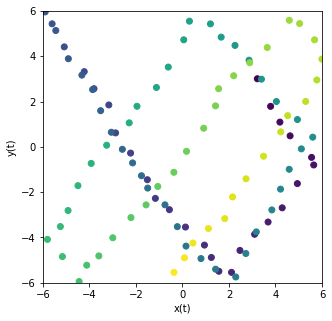

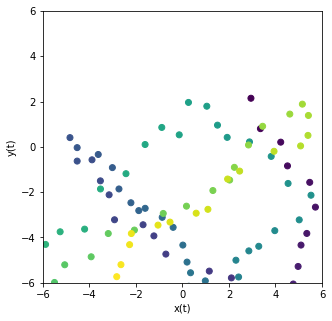

In [27]:
graph_original_trajectory(trajectory, T, s)
graph_inferred_trajectory(positions, T, s)